#### CIFAR exp (varying task sample)

In [1]:
import random
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers
from itertools import product
import pandas as pd

import numpy as np
import pickle

from sklearn.model_selection import StratifiedKFold
from math import log2, ceil

import sys
from joblib import Parallel, delayed
from multiprocessing import Pool

from proglearn import ProgressiveLearner
from proglearn import SimpleArgmaxAverage
from proglearn import NeuralClassificationTransformer, TreeClassificationTransformer
from proglearn import TreeClassificationVoter, KNNClassificationVoter

import tensorflow as tf
from numbers import Number
from collections import Set, Mapping, deque

import time

In [8]:
n_task = 10

In [9]:
def LF_experiment(train_x, train_y, test_x, test_y, ntrees, shift, slot, model, num_points_per_task, acorn=None):

    df = pd.DataFrame()
    single_task_accuracies = np.zeros(10,dtype=float)
    shifts = []
    tasks = []
    base_tasks = []
    accuracies_across_tasks = []
    train_times_across_tasks = []
    single_task_inference_times_across_tasks = []
    multitask_inference_times_across_tasks = []
    model_size = []

    if model == "uf":
        default_transformer_class = TreeClassificationTransformer
        default_transformer_kwargs = {"kwargs" : {"max_depth" : None, "max_features" : "auto"}}

        default_voter_class = TreeClassificationVoter
        default_voter_kwargs = {}

        default_decider_class = SimpleArgmaxAverage


    progressive_learner = ProgressiveLearner(default_transformer_class = default_transformer_class,
                                         default_transformer_kwargs = default_transformer_kwargs,
                                         default_voter_class = default_voter_class,
                                         default_voter_kwargs = default_voter_kwargs,
                                         default_decider_class = default_decider_class)

    for task_ii in range(n_task):
        print("Starting Task {} For Fold {}".format(task_ii, shift))
        if acorn is not None:
            np.random.seed(acorn)

            reduced_sample_no = int(num_points_per_task*(1.29**task_ii))

            print(reduced_sample_no)

        train_start_time = time.time()
        progressive_learner.add_task(
            X = train_x[task_ii*5000+slot*reduced_sample_no:task_ii*5000+(slot+1)*reduced_sample_no],
            y = train_y[task_ii*5000+slot*reduced_sample_no:task_ii*5000+(slot+1)*reduced_sample_no],
            num_transformers = 1 if model == "dnn" else ntrees,
            transformer_voter_decider_split = [0.67, 0.33, 0],
            decider_kwargs = {"classes" : np.unique(train_y[task_ii*5000+slot*reduced_sample_no:task_ii*5000+(slot+1)*reduced_sample_no])}
            )
        train_end_time = time.time()

        train_times_across_tasks.append(train_end_time - train_start_time)
        model_size.append(getsize(progressive_learner))
        print(model_size)

        single_task_inference_start_time = time.time()
        llf_task=progressive_learner.predict(
            X = test_x[task_ii*1000:(task_ii+1)*1000,:], transformer_ids=[task_ii], task_id=task_ii
            )
        single_task_inference_end_time = time.time()
        single_task_accuracies[task_ii] = np.mean(
                llf_task == test_y[task_ii*1000:(task_ii+1)*1000]
                    )
        single_task_inference_times_across_tasks.append(single_task_inference_end_time - single_task_inference_start_time)



        for task_jj in range(task_ii+1):
            multitask_inference_start_time = time.time()
            llf_task=progressive_learner.predict(
                X = test_x[task_jj*1000:(task_jj+1)*1000,:], task_id=task_jj
                )
            multitask_inference_end_time = time.time()

            shifts.append(shift)
            tasks.append(task_jj+1)
            base_tasks.append(task_ii+1)
            accuracies_across_tasks.append(np.mean(
                llf_task == test_y[task_jj*1000:(task_jj+1)*1000]
                ))
            multitask_inference_times_across_tasks.append(multitask_inference_end_time - multitask_inference_start_time)

    df['data_fold'] = shifts
    df['task'] = tasks
    df['base_task'] = base_tasks
    df['accuracy'] = accuracies_across_tasks
    df['multitask_inference_times'] = multitask_inference_times_across_tasks


    df_single_task = pd.DataFrame()
    df_single_task['task'] = range(1, 11)
    df_single_task['data_fold'] = shift
    df_single_task['accuracy'] = single_task_accuracies
    df_single_task['single_task_inference_times'] = single_task_inference_times_across_tasks
    df_single_task['train_times'] = train_times_across_tasks
    df_single_task['model_size'] = model_size

    summary = (df,df_single_task)
    file_to_save = 'result/result/increased_sample_'+model+str(ntrees)+'_'+str(shift)+'_'+str(slot)+'.pickle'
    with open(file_to_save, 'wb') as f:
        pickle.dump(summary, f)

In [15]:
# with open('data.pickle', 'wb') as f:
#     pickle.dump(data, f)

In [10]:
# The method randomly selects training and testing subsets from the original datasets,
# making cross-validation on program results possible.

def cross_val_data(data_x, data_y, num_points_per_task, total_task=n_task, shift=1):
    x = data_x.copy()
    y = data_y.copy()
    idx = [np.where(data_y == u)[0] for u in np.unique(data_y)]

    batch_per_task=5000//num_points_per_task
    sample_per_class = num_points_per_task//total_task
    test_data_slot=100//batch_per_task

    for task in range(total_task):
        for batch in range(batch_per_task):
            for class_no in range(task*10,(task+1)*10,1):
                indx = np.roll(idx[class_no],(shift-1)*100)

                if batch==0 and class_no==0 and task==0:
                    train_x = x[indx[batch*sample_per_class:(batch+1)*sample_per_class],:]
                    train_y = y[indx[batch*sample_per_class:(batch+1)*sample_per_class]]
                    test_x = x[indx[batch*test_data_slot+500:(batch+1)*test_data_slot+500],:]
                    test_y = y[indx[batch*test_data_slot+500:(batch+1)*test_data_slot+500]]
                else:
                    train_x = np.concatenate((train_x, x[indx[batch*sample_per_class:(batch+1)*sample_per_class],:]), axis=0)
                    train_y = np.concatenate((train_y, y[indx[batch*sample_per_class:(batch+1)*sample_per_class]]), axis=0)
                    test_x = np.concatenate((test_x, x[indx[batch*test_data_slot+500:(batch+1)*test_data_slot+500],:]), axis=0)
                    test_y = np.concatenate((test_y, y[indx[batch*test_data_slot+500:(batch+1)*test_data_slot+500]]), axis=0)

    return train_x, train_y, test_x, test_y

In [11]:
def run_parallel_exp(data_x, data_y, n_trees, model, num_points_per_task, slot=0, shift=1):
    train_x, train_y, test_x, test_y = cross_val_data(data_x, data_y, 500, shift=shift)

    if model == "dnn":
        config = tf.compat.v1.ConfigProto()
        config.gpu_options.allow_growth = True
        sess = tf.compat.v1.Session(config=config)
        with tf.device('/gpu:'+str(shift % 4)):
            LF_experiment(train_x, train_y, test_x, test_y, n_trees, shift, slot, model, num_points_per_task, acorn=12345)
    else:
        LF_experiment(train_x, train_y, test_x, test_y, n_trees, shift, slot, model, num_points_per_task, acorn=12345)


In [17]:
def getsize(obj_0):
    """Recursively iterate to sum size of object & members."""
    _seen_ids = set()
    def inner(obj):
        obj_id = id(obj)
        if obj_id in _seen_ids:
            return 0
        _seen_ids.add(obj_id)
        size = sys.getsizeof(obj)
        if isinstance(obj, zero_depth_bases):
            pass # bypass remaining control flow and return
        elif isinstance(obj, (tuple, list, Set, deque)):
            size += sum(inner(i) for i in obj)
        elif isinstance(obj, Mapping) or hasattr(obj, iteritems):
            size += sum(inner(k) + inner(v) for k, v in getattr(obj, iteritems)())
        # Check for custom object instances - may subclass above too
        if hasattr(obj, '__dict__'):
            size += inner(vars(obj))
        if hasattr(obj, '__slots__'): # can have __slots__ with __dict__
            size += sum(inner(getattr(obj, s)) for s in obj.__slots__ if hasattr(obj, s))
        return size
    return inner(obj_0)

In [19]:
try: # Python 2
    zero_depth_bases = (basestring, Number, xrange, bytearray)
    iteritems = 'iteritems'
except NameError: # Python 3
    zero_depth_bases = (str, bytes, Number, range, bytearray)
    iteritems = 'items'

In [12]:
model = "uf"
num_points_per_task = 500
total_slots = 1 #5000//num_points_per_task

In [10]:
# (X_train, y_train), (X_test, y_test) = keras.datasets.cifar100.load_data()
# data = ((X_train, y_train),(X_test, y_test))

In [13]:
with open('data.pickle', 'rb') as f:
     data = pickle.load(f)

In [14]:
(X_train, y_train) = data[0]
(X_test, y_test) = data[1]

In [15]:
data_x = np.concatenate([X_train, X_test])
if model == "uf":
    data_x = data_x.reshape((data_x.shape[0], data_x.shape[1] * data_x.shape[2] * data_x.shape[3]))
data_y = np.concatenate([y_train, y_test])
data_y = data_y[:, 0]

In [21]:
if model == "uf":
    slot_fold = range(total_slots)
    shift_fold = range(1,7,1)
    n_trees=[10]
    iterable = product(n_trees,shift_fold,slot_fold)
    Parallel(n_jobs=-2,verbose=1)(
        delayed(run_parallel_exp)(
                data_x, data_y, ntree, model, num_points_per_task, slot=slot, shift=shift
                ) for ntree,shift,slot in iterable
                )

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
[Parallel(n_jobs=-2)]: Done   6 out of   6 | elapsed:  5.0min finished


In [23]:
with open('result/result/increased_sample_uf10_1_0.pickle', 'rb') as f:
     r1 = pickle.load(f)

#### CIFAR rotation exp

In [47]:
import matplotlib.pyplot as plt
import random
import pickle
# from skimage.transform import rotate
from scipy import ndimage
from skimage.util import img_as_ubyte
from joblib import Parallel, delayed
from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble.forest import _generate_sample_indices
import numpy as np
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from itertools import product
import keras

from keras import layers

from joblib import Parallel, delayed
from multiprocessing import Pool

import tensorflow as tf

# from numba import cuda

from proglearn.progressive_learner import ProgressiveLearner
from proglearn.deciders import SimpleArgmaxAverage
from proglearn.transformers import TreeClassificationTransformer, NeuralClassificationTransformer
from proglearn.voters import TreeClassificationVoter, KNNClassificationVoter

In [48]:
def cross_val_data(data_x, data_y, total_cls=10):
    x = data_x.copy()
    y = data_y.copy()
    idx = [np.where(data_y == u)[0] for u in np.unique(data_y)]


    for i in range(total_cls):
        indx = idx[i]#np.roll(idx[i],(cv-1)*100)
        random.shuffle(indx)

        if i==0:
            train_x1 = x[indx[0:250],:]
            train_x2 = x[indx[250:500],:]
            train_y1 = y[indx[0:250]]
            train_y2 = y[indx[250:500]]

            test_x = x[indx[500:600],:]
            test_y = y[indx[500:600]]
        else:
            train_x1 = np.concatenate((train_x1, x[indx[0:250],:]), axis=0)
            train_x2 = np.concatenate((train_x2, x[indx[250:500],:]), axis=0)
            train_y1 = np.concatenate((train_y1, y[indx[0:250]]), axis=0)
            train_y2 = np.concatenate((train_y2, y[indx[250:500]]), axis=0)

            test_x = np.concatenate((test_x, x[indx[500:600],:]), axis=0)
            test_y = np.concatenate((test_y, y[indx[500:600]]), axis=0)


    return train_x1, train_y1, train_x2, train_y2, test_x, test_y

In [53]:
def LF_experiment(data_x, data_y, angle, model, granularity, reps=1, ntrees=29, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)

    errors = np.zeros(2)

    with tf.device('/gpu:'+str(int(angle //  granularity) % 4)):
        for rep in range(reps):
            train_x1, train_y1, train_x2, train_y2, test_x, test_y = cross_val_data(data_x, data_y, total_cls=10)


            #change data angle for second task
            # tmp_data = train_x2.copy()
            # _tmp_ = np.zeros((32,32,3), dtype=int)
            # total_data = tmp_data.shape[0]

            # for i in range(total_data):
            #     tmp_ = image_aug(tmp_data[i],angle)
            #     tmp_data[i] = tmp_
            tmp_data = tmp_data_all[angle]

            if model == "uf":
                train_x1 = train_x1.reshape((train_x1.shape[0], train_x1.shape[1] * train_x1.shape[2] * train_x1.shape[3]))
                tmp_data = tmp_data.reshape((tmp_data.shape[0], tmp_data.shape[1] * tmp_data.shape[2] * tmp_data.shape[3]))
                test_x = test_x.reshape((test_x.shape[0], test_x.shape[1] * test_x.shape[2] * test_x.shape[3]))

            if model == "uf":
                default_transformer_class = TreeClassificationTransformer
                default_transformer_kwargs = {"kwargs" : {"max_depth" : 30}}

                default_voter_class = TreeClassificationVoter
                default_voter_kwargs = {}

                default_decider_class = SimpleArgmaxAverage


            progressive_learner = ProgressiveLearner(default_transformer_class = default_transformer_class,
                                         default_transformer_kwargs = default_transformer_kwargs,
                                         default_voter_class = default_voter_class,
                                         default_voter_kwargs = default_voter_kwargs,
                                         default_decider_class = default_decider_class)

            progressive_learner.add_task(
                X = train_x1,
                y = train_y1,
                transformer_voter_decider_split = [0.67, 0.33, 0],
                decider_kwargs = {"classes" : np.unique(train_y1)}
            )

            progressive_learner.add_transformer(
                X = tmp_data,
                y = train_y2,
                transformer_data_proportion = 1,
                backward_task_ids = [0]
            )


            llf_task1=progressive_learner.predict(test_x, task_id=0)
            llf_single_task=progressive_learner.predict(test_x, task_id=0, transformer_ids=[0])

            errors[1] = errors[1]+(1 - np.mean(llf_task1 == test_y))
            errors[0] = errors[0]+(1 - np.mean(llf_single_task == test_y))

    errors = errors/reps
    print("Errors For Angle {}: {}".format(angle, errors))
    with open('results/angle_'+str(angle)+'_'+model+'.pickle', 'wb') as f:
        pickle.dump(errors, f, protocol = 2)

In [50]:
# def image_aug(pic, angle, centroid_x=23, centroid_y=23, win=16, scale=1.45):
#     im_sz = int(np.floor(pic.shape[0]*scale))
#     pic_ = np.uint8(np.zeros((im_sz,im_sz,3),dtype=int))

#     pic_[:,:,0] = ndimage.zoom(pic[:,:,0],scale)

#     pic_[:,:,1] = ndimage.zoom(pic[:,:,1],scale)
#     pic_[:,:,2] = ndimage.zoom(pic[:,:,2],scale)

#     image_aug = rotate(pic_, angle, resize=False)
#     #print(image_aug.shape)
#     image_aug_ = image_aug[centroid_x-win:centroid_x+win,centroid_y-win:centroid_y+win,:]

#     return img_as_ubyte(image_aug_)

In [42]:
model = "uf"
granularity = 5
reps = 4

In [43]:
data_x = np.concatenate([X_train, X_test])
data_y = np.concatenate([y_train, y_test])
data_y = data_y[:, 0]

In [44]:
def perform_angle(angle):
    LF_experiment(data_x, data_y, angle, model, granularity, reps=reps, ntrees=16, acorn=1)

In [52]:
with open('tmp_data_all.pickle', 'rb') as f:
     tmp_data_all = pickle.load(f)

In [54]:
angles = np.arange(0, 180,30)
with Pool(96) as p:
    p.map(perform_angle, angles)

Errors For Angle 30: [0.7375  0.72875]
Errors For Angle 0: [0.743 0.719]
Errors For Angle 120: [0.744   0.72825]
Errors For Angle 60: [0.75175 0.7375 ]
Errors For Angle 150: [0.741   0.72325]
Errors For Angle 90: [0.73325 0.72   ]


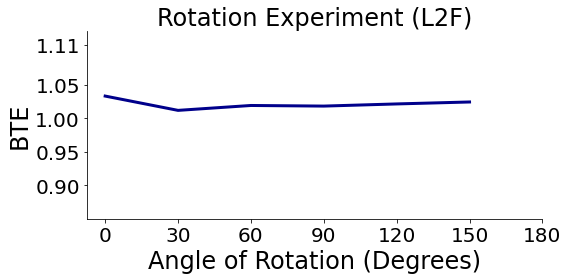

In [59]:
import seaborn as sns
# %%
alg_name = ['L2F']
angles = np.arange(0,180,30)
tes = [[] for _ in range(len(alg_name))]

for algo_no,alg in enumerate(alg_name):
    for angle in angles:
        if alg=='L2F':
            orig_error, transfer_error = pickle.load(
                open("results/angle_" + str(angle) + "_uf.pickle", "rb")
                )
            tes[algo_no].append(orig_error / transfer_error)

# %%
clr = ["#00008B", "#e41a1c", "#4daf4a", "#984ea3", "#ff7f00", "#CCCC00"]
c = sns.color_palette(clr, n_colors=len(clr))
fig, ax = plt.subplots(1,1, figsize=(8,4))

for alg_no,alg in enumerate(alg_name):
    if alg_no<2:
        ax.plot(angles,tes[alg_no], c=c[alg_no], label=alg_name[alg_no], linewidth=3)
    else:
        ax.plot(angles,tes[alg_no], c=c[alg_no], label=alg_name[alg_no])

ax.set_yticks([.9,.95, 1, 1.05,1.11])
ax.set_ylim([0.85,1.13])
ax.set_xticks([0,30,60,90,120,150,180])
ax.tick_params(labelsize=20)
ax.set_xlabel('Angle of Rotation (Degrees)', fontsize=24)
ax.set_ylabel('BTE', fontsize=24)
ax.set_title("Rotation Experiment (L2F)", fontsize = 24)
right_side = ax.spines["right"]
right_side.set_visible(False)
top_side = ax.spines["top"]
top_side.set_visible(False)
plt.tight_layout()